In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

This notebook shows how to construct the number of excess deaths (relative to a counterfactual 2020) from INSEE data on total deaths. It then compares these excess deaths to the counterfactual including Covid-19 deaths.

- The source for the INSEE data on total deaths is https://www.insee.fr/fr/information/4470857 for 2020, 2019 and 2018. For years up tp 2018, data are here: https://www.insee.fr/fr/statistiques/4204054?sommaire=4204068#consulter-sommaire $\to$ "T79JDEC – Répartition quotidienne des décès (Séries depuis 1968 pour la France métropolitaine, 1998 pour la France entière)"

- The source for the official Covid-19 deaths is https://dashboard.covid19.data.gouv.fr/

**NOTE** The first version of the analysis for France (in the same directory) had only used data for 2018, 2019, 2020. Here we are using data since 2015. Note that the data on total deaths for 2020 excludes the Departement of Bouches-du-Rhône, which contains the city of Marseilles. 

# 1) Processing the INSEE data

## 1.1) Up to 2018

In [2]:
def convert_months(month):
    
    months = {}
    months['Août'] = '08'
    months['Avril'] = '04'
    months['Décembre'] = '12'
    months['Février'] = '02'
    months['Janvier'] = '01'
    months['Juillet'] = '07'
    months['Juin'] = '06'
    months['Mai'] = '05'
    months['Mars'] = '03'
    months['Novembre'] = '11'
    months['Octobre'] = '10'
    months['Septembre'] = '09'
    
    return months[month]

In [3]:
def process_sheet(sheet_name):
    
    df = pd.read_excel('./total_deaths/T79JDEC.xls', sheet_name=sheet_name, skiprows=3)
    df = df.iloc[1:-1,:-1].reset_index(drop=True).copy(deep=True)
    df = df.replace('so', np.nan)
    df.columns = ['ANNEE'] + list(df.columns[1:])
    df['ANNEE'] = df['ANNEE'].fillna(method='ffill')
    df.index = [df.ANNEE, df.JOUR]
    df = df.drop(['ANNEE', 'JOUR'], axis=1)
    df = pd.DataFrame(df.stack())
    df.reset_index(inplace=True)
    df.columns = ['annee', 'mois', 'jour', 'deces']
    df.index = [df.mois, df.jour, df.annee]
    df = df.drop(['mois', 'jour', 'annee'], axis=1)
    df = df.unstack()
    df.reset_index(inplace=True)
    df.columns = df.columns.droplevel()
    df.columns = ['mois', 'day'] + list(df.columns[2:])
    df['month'] = df.mois.apply(lambda x: convert_months(x))
    del df['mois']
    df = df.iloc[:,[-1, 0] + list(range(1,df.shape[1]-1))]
    df = df.sort_values(by=['month', 'day']).reset_index(drop=True).copy(deep=True)
    df = df[['month', 'day'] + ['{}'.format(yr) for yr in range(2015, 2019)]]
    df = df[df.month=='03'].reset_index(drop=True)
    for yr in range(2015, 2019):
        df['{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    
    return df    

"FE" = France Entiere. 

In [4]:
fe = process_sheet('FE')
fe.columns = ['month', 'day'] + ['{}'.format(yr) for yr in range(2015, 2019)]

## 1.2) 2018-2020 excluding Bouche du Rhone

In [5]:
df = pd.read_csv('./total_deaths/total_deaths_france.csv')
df['day'] = np.arange(1,32).astype('str')
df['day'] = ('0' + df['day']).str[-2:]
df['month'] = '03'
del df['date']
df = df[['month', 'day', '2019', '2020']]
df = pd.merge(fe, df,  on=['month', 'day'], how='outer')

In [6]:
df = df[~pd.isnull(df['2020'])].reset_index(drop=True).copy(deep=True)

computing the average of the cumulative totals across 2015-2019

In [7]:
df['cs_1519'] = df.loc[:,['{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df[['month', 'day', '2020', 'cs_1519']].copy(deep=True)

computing daily growth rates 2018-2019

In [8]:
df['daily_growth'] = df.cs_1519 / df.cs_1519.shift(1)

extrapolating forward

In [9]:
df['counterfactual_2020'] = 0
df.loc[0,'counterfactual_2020'] = df.loc[df.day=='01', '2020'].values[0]

In [10]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual_2020'] = df.loc[i-1,'counterfactual_2020'] * df.loc[i,'daily_growth']
df = df.drop(['cs_1519', 'daily_growth'], axis=1)

creating a date column

In [11]:
df['date'] = '2020-' + df.month + '-' + df.day
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')
df = df[['date', '2020', 'counterfactual_2020']].reset_index(drop=True).copy(deep=True)

# 2) Processing the official covid data from Sante Publique France

In [12]:
official = pd.read_csv('./COVID_deaths/covid_deaths_france.csv')

In [13]:
official['date'] = pd.to_datetime(official['date'] , format='%&%m%d', errors='ignore')
official['covid_19'] = official.hopital + official.EHPD_EMS
official = official[['covid_19', 'date']]

# 3) Merging and plotting

In [14]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual_2020 + df.covid_19
del df['covid_19']
df

,date,2020,counterfactual_2020,counterfactual_2020_covid
0,2020-03-01,1695.0,1695.000000,1695.000000
1,2020-03-02,3413.0,3415.648744,3418.648744
2,2020-03-03,5101.0,5113.741146,5117.741146
3,2020-03-04,6801.0,6794.734385,6798.734385
4,2020-03-05,8496.0,8461.175145,8468.175145
5,2020-03-06,10231.0,10124.887315,10133.887315
6,2020-03-07,11824.0,11783.506117,11799.506117
7,2020-03-08,13418.0,13418.840953,13437.840953
8,2020-03-09,15136.0,15071.820670,15096.820670
9,2020-03-10,16840.0,16739.534771,16772.534771


In [15]:
df.index=df.date
del df['date']

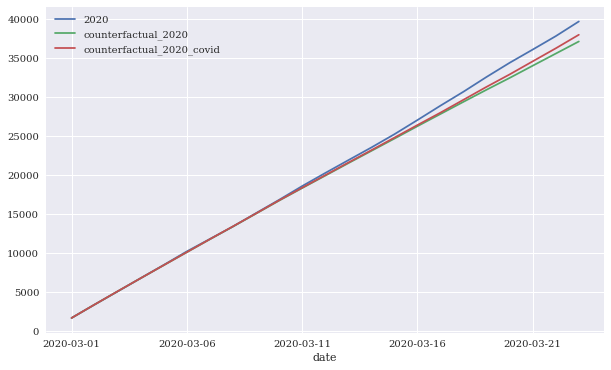

In [16]:
df.plot(figsize=(10,6))
plt.show()

In [17]:
print('Official covid-deaths: {} = red-green'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = blue-green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = blue-red'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 860.0 = red-green
Excess deaths: 2565.0 = blue-green
Unexplained excess deaths: 1705.0 = blue-red
